This jupyter notebook retrieve latest laptop data from database,
then analyze laptop brand price and market share information.

In [2]:
import pandas as pd
import numpy as np

import configparser
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read config file
config_path = '/Users/margaret/OneDrive/Documents/Twitter/Scraping_Laptop/config.cfg'
config = configparser.ConfigParser()
config.read(config_path)

['/Users/margaret/OneDrive/Documents/Twitter/Scraping_Laptop/config.cfg']

In [4]:
def connect_db(config):
    """
    Connect database and return cursor variable, connection object
    
    input:
    config - contain database connection info
    
    output:
    cur - cursor variable
    conn - connection object
    """
    conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['DB'].values()))
    
    # get cursor variable 
    cur = conn.cursor()
    return cur, conn

In [5]:
def get_latest_laptop_info():
    """
    - Connect database
    - Retrieve data from factlaptop table of the latest date
    
    input: None
    
    output:
    df - laptop data as DataFrame format
    """
    # connect database and get cursor variable, connection object
    cur, conn = connect_db(config)
    
    # get data
    cur.execute("""SELECT   dimlaptop.name as laptop_name, 
                            dimbrand.name as brand_name,
                            factlaptopinfo.price::float as price,
                            factlaptopinfo.availability as availability,
                            factlaptopinfo.review_num as review_num
                        FROM factlaptopinfo, dimlaptop, dimbrand
                    WHERE time IN (SELECT MAX(time) FROM factlaptopinfo)
                        AND factlaptopinfo.laptop_key = dimlaptop.laptop_key
                        AND factlaptopinfo.brand_key = dimbrand.brand_key;""")
    
    # get column names
    colnames = [desc[0] for desc in cur.description]
    
    # convert data into pandas dataframe
    df = pd.DataFrame(data=cur.fetchall(), columns=colnames)
    
    # close connection
    conn.close()
    return df

In [6]:
# get latest laptop price/availability/# of review info
df = get_latest_laptop_info()

# Apple, HP, Lenovo, Dell are top 4 brands
# In total, they account for 80% of the total SKUs

In [7]:
# get the number of sku for each brand
number_sku_per_brand = df.groupby(['brand_name']).size()
top_4_market_share = number_sku_per_brand.nlargest(4).sum() / number_sku_per_brand.sum()
print("The top 4 account for {:.2f}% of the total SKUs".format(top_4_market_share*100))

The top 4 account for 80.15% of the total SKUs


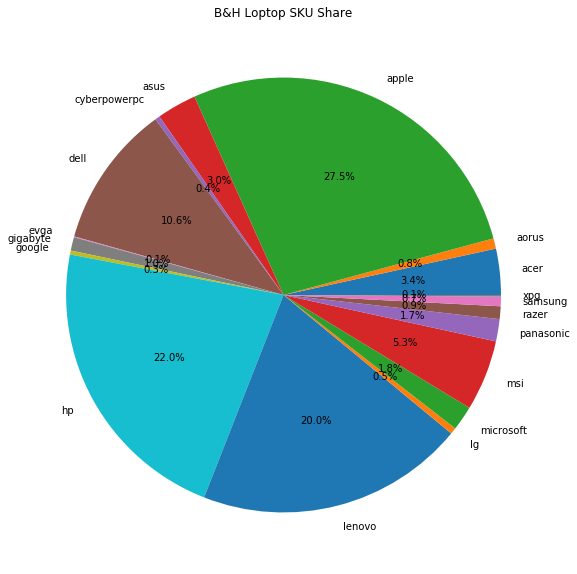

In [8]:
# get plot object
fig, ax = plt.subplots(figsize=(10, 10))

# plot the number of sku for each brand as pie chart
ax.pie(x=number_sku_per_brand, labels=number_sku_per_brand.index, autopct='%1.1f%%')

# set title
ax.set_title('B&H Loptop SKU Share')
plt.show()

# Panasonic, Apple, Switchblade, Razar, Gigabyte are 5 high-end brands based on average laptop price scraped from B&H

In [9]:
# get number of SKU, median price for each brand
df_brand = pd.concat([df.groupby(['brand_name']).size().rename('SKU_size'), df.groupby(['brand_name'])['price'].median()], axis=1).reset_index()

df_brand.nlargest(6, 'price')

,brand_name,SKU_size,price
2,apple,466,3399.000
14,panasonic,28,3327.225
15,razer,16,2599.990
7,gigabyte,17,2499.000
1,aorus,13,1999.000
6,evga,1,1799.990


# However, most brands with average price greater than 2000$ have a small size SKU except Apple

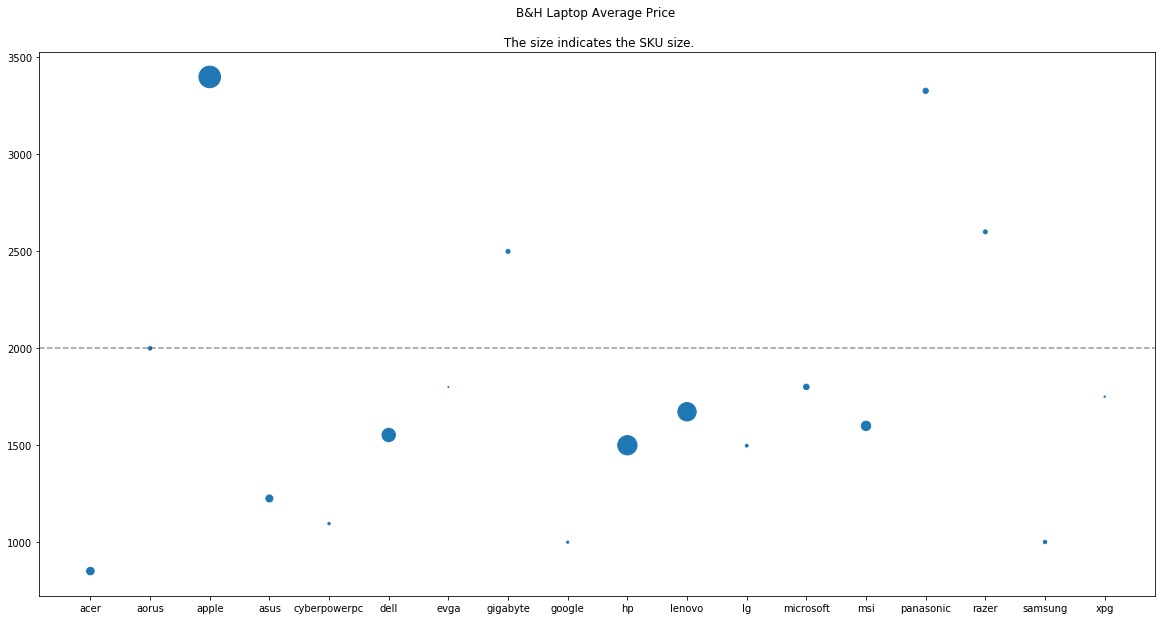

In [10]:
# get number of SKU, median price for each brand and plot it
df_brand = pd.concat([df.groupby(['brand_name']).size().rename('SKU_size'), df.groupby(['brand_name'])['price'].median()], axis=1).reset_index()

# get plot object
fig, ax = plt.subplots(figsize=(20, 10))

# make scatter plot
ax.scatter(x=df_brand.index, y=df_brand['price'], 
            s=df_brand['SKU_size'])

# plot a horizontal line at 2000$
ax.axhline(y=2000, xmin=min(df_brand.index), xmax=max(df_brand.index), 
           color = 'black', alpha=0.4, linestyle='--')

# set title
ax.set_title('B&H Laptop Average Price \n\n The size indicates the SKU size.')

# set label for x-axis 
plt.xticks(df_brand.index, df_brand['brand_name'].values)
plt.show()

# Lenovo, Acer, HP, ASUS, Dell have high-end products which look like outliers from price distribution chart

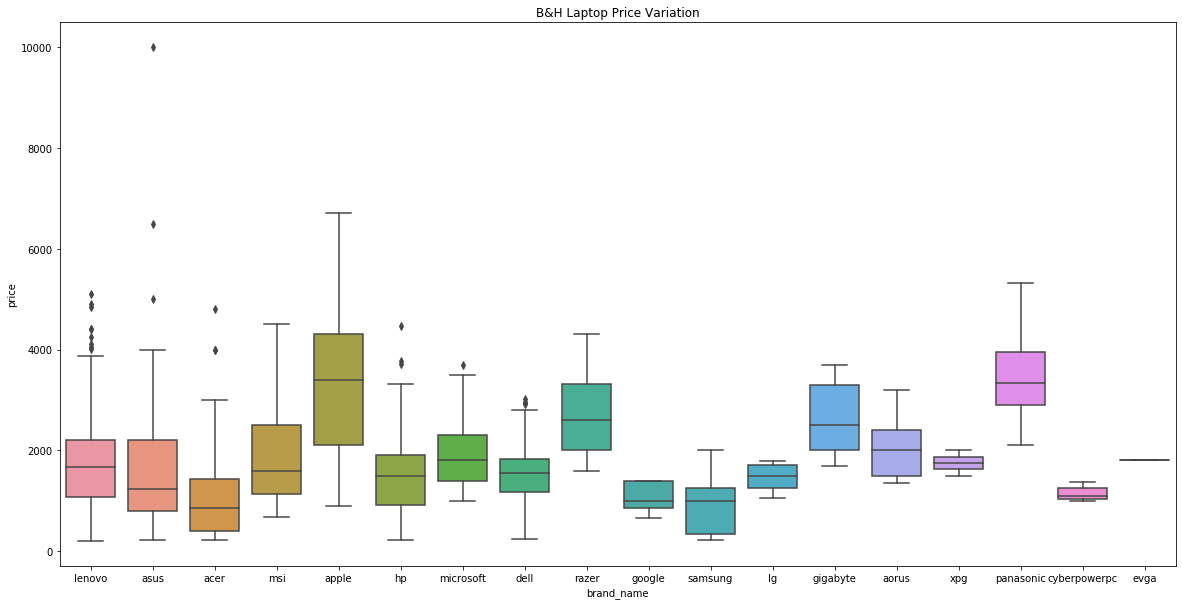

In [11]:
# get plot object
fig, ax = plt.subplots(figsize=(20, 10))

# plot price Variation of each brand as box chart
sns.boxplot(data=df, x='brand_name', y='price', ax=ax)

# set title
ax.set_title('B&H Laptop Price Variation')
plt.show()

# HP has the most SKU back-ordered/on-the-way
# ASUS has the highest percentage of SKU back-ordered/on-the-way

In [12]:
# number of back-ordered and more-on-the-way for each brand
df_more = df.loc[df['availability'].isin(['back-ordered', 'more on the way'])]

# percentage of number of on-the-way SKUs
df_otw_pert = df_more.groupby(['brand_name']).size()/df.groupby(['brand_name']).size() 

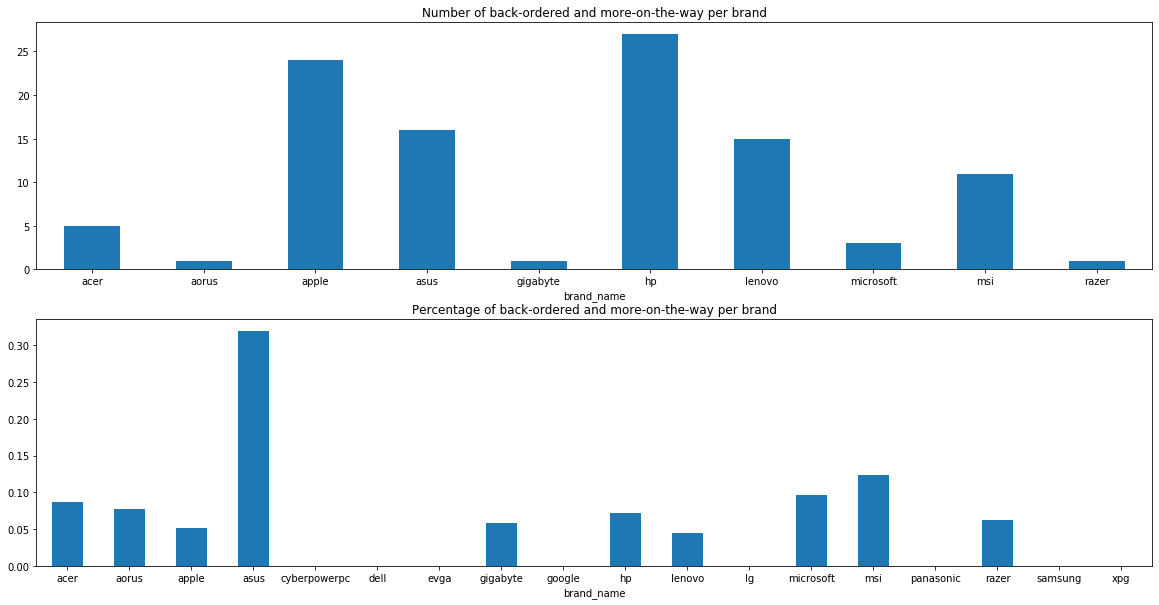

In [13]:
# get axes object
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# plot number of back-ordered and more-on-the-way for each brand
df_more.groupby(['brand_name']).size().plot(kind='bar', figsize=(20,15), 
                                                title='Number of back-ordered and more-on-the-way per brand',
                                                rot=0, ax=ax[0])

# plot percentage of number of on-the-way SKUs
df_otw_pert.plot(kind='bar', figsize=(20,10), 
                 title='Percentage of back-ordered and more-on-the-way per brand',
                 rot=0, ax=ax[1])
plt.show()